# Convolutional neural networks for neural style transfer

This notebook is an attempt to implement neural style transfer that is how we can use neural networks to transfer artificial features from one image onto another.In order to complete this project I have followed research papers like ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) , [Paper on Deep CNN](https://arxiv.org/pdf/1409.1556.pdf)   and blogs like [Neural Style Transfer](https://towardsdatascience.com/neural-style-transfer-4d7c8138e7f6) , [Artistic Style Transfer](https://medium.com/data-science-group-iitr/artistic-style-transfer-with-convolutional-neural-network-7ce2476039fd) ,[CNN for Artistic Style Transfer](https://harishnarayanan.org/writing/artistic-style-transfer/) and [Picking an optimizer for Style Transfer](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b) .


In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## Loading and preprocessing the content and style images

The content image is a Japanese Garden and style image is a famous self portrait image of Picasso .

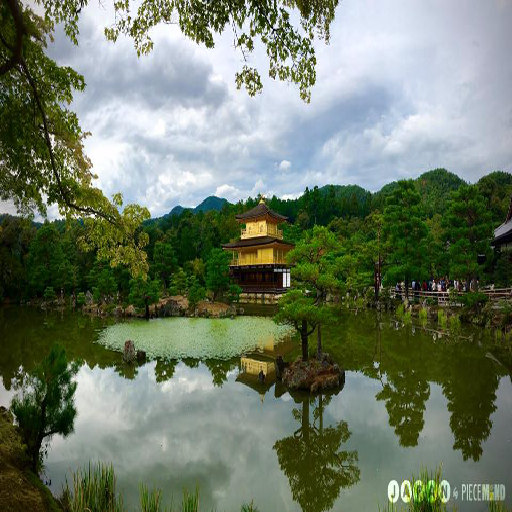

In [2]:
height = 512
width = 512

content_image_path = 'images/japanese_garden.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

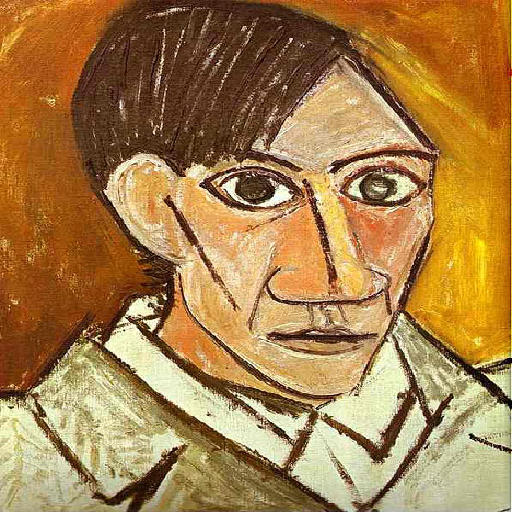

In [3]:
style_image_path = 'images/picasso_selfportrait.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

Then, we convert these images into a form suitable for numerical processing.This step is required so that we can later concatenate the representations of these  images into a common data structure.

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Now, we perform two transformations:

1. Subtract the mean RGB value from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* .

In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Now we load the arrays into TensorFlow variables.Placeholders and variables are key tools for using computational graphs in TensorFlow, so we use a placeholder variable to store the *combined* image that retains the content of content image while incorporating the style of the style image.

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Reusing a model pre-trained for image classification to define loss functions

The core idea introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the *feature spaces* provided by one such model to independently work with content and style of images.

We are using 16 layer model (VGG16).

Also, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the part of the model marked in green in the table below.

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

In [8]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

We are making a list of these names for easy reference to individual layers in future.

In [9]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

As we have covered all items we wanted in the table (the cells marked in green). Notice also that because we provided Keras with a concrete input tensor, the various TensorFlow tensors get well-defined shapes.

---

I am trying to show that the [style transfer problem can be posed as an optimisation problem] (https://harishnarayanan.org/writing/artistic-style-transfer/), where the loss function we want to minimise can be decomposed into three distinct parts: the *content loss*, the *style loss* and the *total variation loss*.

The relative importance of these terms are determined by a set of scalar weights, which are arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates satisfactorily output .

In [10]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [11]:
loss = backend.variable(0.)

### The content loss

For calculating content loss, we draw the content feature from `block2_conv2`

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [12]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### Calculating style loss

(Referred Paper- [a paper explaining this idea](https://arxiv.org/abs/1606.01286).)

For the style loss, we first define *Gram matrix*. 
*Gram matrix* - The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. 

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.


In [13]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

In [14]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### Calculating total variation loss

In order to solve the optimisation problem, we have to add another term called [total variation loss](http://arxiv.org/abs/1412.0035) (a regularisation term) that encourages spatial smoothness.
Now, we need to reduce the 'total_variation_weight' and keep an eye on noise-level .

In [15]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Defining needed gradients and solving the optimisation problem

[Following This Blog](https://harishnarayanan.org/writing/artistic-style-transfer/) 

Now , we define gradients of the total loss relative to the combination image, and use these gradients to reduce loss function and improve combination image .

In [16]:
grads = backend.gradients(loss, combination_image)

Now we introduce an `Evaluator` class that computes loss and gradients in one pass while retrieving them via two separate functions, `loss` and `grads`. This is done because `scipy.optimize` requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [17]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

We use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon combination Image.

We run 10 iterations. 

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 11

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


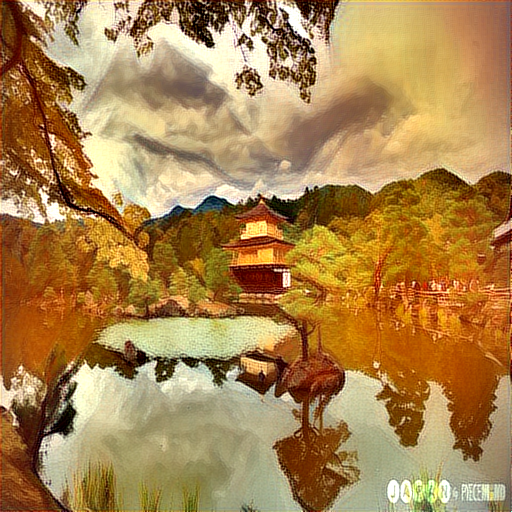

In [38]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)